In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC`


In [3]:
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using DataFrames
using CSV
using Distances
using NNlib
using Discretizers
using EvalMetrics
using Random
using LaTeXStrings
# discretization length for AUPRC
Nq = 500
# plot sizes
PLT_CELL = 500
# figure directory
FIG_DIR = "."
# 
DATA_PATH="../../data/mESC/"

[ Info: Precompiling OptimalTransport [7e02d93a-ae51-4f58-b602-d97af76e3b33]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/backends.jl:43
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]


"../../data/mESC/"

In [6]:
# load logarithmized counts
X = npzread(string(DATA_PATH, "X.npy"))
X = relu.(X .- 1e-2);
# gene names
try
    global genes = Array(CSV.read(string(DATA_PATH, "genes.txt"), DataFrame)[:, 2])
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)];
end
# PCA coords, etc.
X_pca = npzread(string(DATA_PATH, "X_pca.npy"))
P = npzread(string(DATA_PATH, "P_statot.npy"))
C = npzread(string(DATA_PATH, "C.npy"))
dpt = npzread(string(DATA_PATH, "dpt.npy"));
# reference dataset
J = npzread(string(DATA_PATH, "J.npy"));
J[diagind(J)] .= 0;
J_escape = npzread(string(DATA_PATH,"J_ESCAPE.npy"));
J_escape[diagind(J_escape)] .= 0;

In [7]:
# neighbourhood kernel
R = npzread(string(DATA_PATH, "R.npy"))
# transition matrices
k = 1
Q = to_backward_kernel(P)
P_sp = sparse((P^k))
QT_sp = sparse((Q^k)')
R_sp = sparse(R);

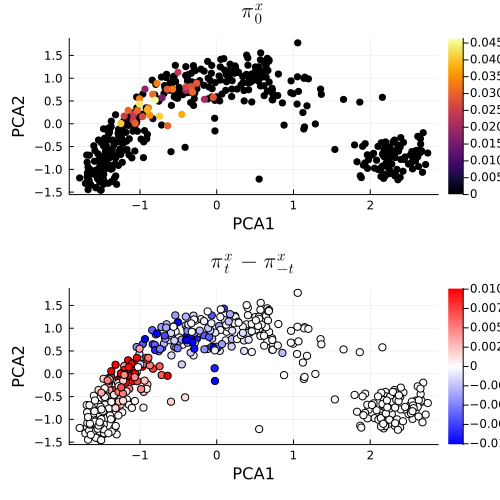

In [8]:
# visualise 
p0 = R[sortperm(dpt)[250], :]
plt=plot(scatter(X_pca[sortperm(p0), 1], X_pca[sortperm(p0), 2]; marker_z = sort(p0), markerstrokewidth = 0, alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"π_0^x"), 
    scatter(X_pca[:, 1], X_pca[:, 2]; marker_z = P_sp'*p0 - QT_sp*p0, color = :bwr, clim = (-0.0101, 0.0101), alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"\pi^x_{t} - \pi^x_{-t}"); legend = nothing, layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "mESC_pca_densities.pdf"))
plt

In [9]:
TE = npzread("TE_locate.npy");
G = npzread("G_locate.npy");
agg_fun = x -> mean(x[dpt .< quantile(dpt, 0.9), :]; dims = 1)

#3 (generic function with 1 method)

In [10]:
A = reshape(pmean(G, 1e2; dims = 1), size(X, 2), size(X, 2))
G = apply_cdf_norm(G, A .+ 1e-9);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


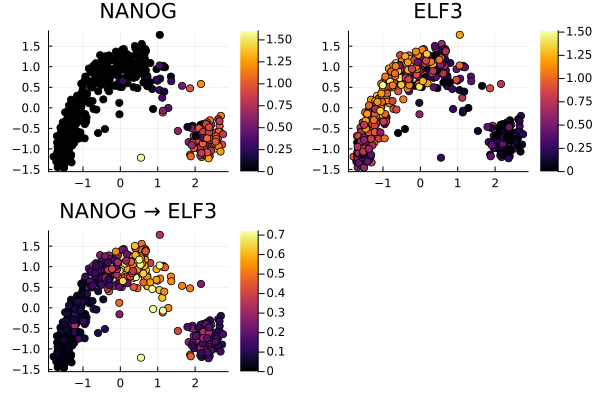

In [11]:
# g1 = "POU5F1"
g1 = "NANOG"
g2 = "ELF3"
plot(scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g1, genes)], title = g1), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g2, genes)], title = g2), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = reshape(G, :, size(X, 2), size(X, 2))[:, findfirst(x -> x == g1, genes), findfirst(x -> x == g2, genes)], 
        title = "$(g1) → $(g2)", clim = (0, quantile(vec(G[G .> 0]), 0.99))); legend = nothing)

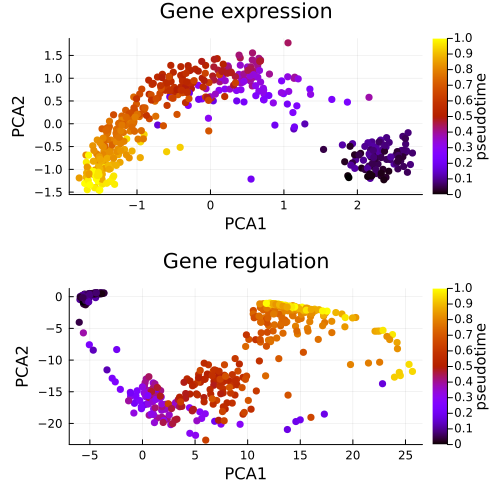

In [12]:
using MultivariateStats
M = fit(PCA, G'; maxoutdim = 3)
G_pca = (M.proj' * G')'
plt1=scatter(X_pca[:, 1], X_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene expression", label = nothing)
plt2=scatter(G_pca[:, 1], G_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene regulation", label = nothing)
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), layout = (2, 1))
savefig(string(FIG_DIR, "mESC_pca_plots.pdf"))
plt

In [13]:
# NMF
using CUDA
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
L = sparse(npzread("L_locate.npy"))

Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(G, 1)), I(size(G, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     8; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 1_000, initialize = :nmf, print_iter = 100, dictionary = true, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
# U .*= mean(V; dims = 1)
# V ./= mean(V; dims = 1);

A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end

npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


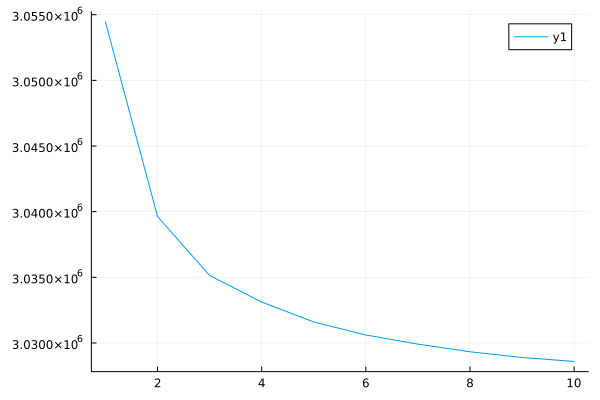

In [14]:
plot(trace)

In [16]:
# NTF
# Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
# S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
#                      [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
#                      cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
#                      [1, 1, 1],
#                      [1, 1, 1],
#                      10.0,
#                      0.0,
#                      32; iter = 2_500, dictionary = false, η = 1.0);

In [17]:
# ntf_atoms = [x*y' for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];
# A[1] .*= cu(mean.(ntf_atoms)')
# A[2] ./= cu(sqrt.(mean.(ntf_atoms))')
# A[3] ./= cu(sqrt.(mean.(ntf_atoms))')
# ntf_atoms ./= cu(mean.(ntf_atoms));

In [18]:
# for i = 1:length(A)
#     npzwrite("A_$i.npy", Array(A[i]))
# end

In [19]:
# plot(trace)

In [30]:
# comparisons
G_symm = locaTE.symm_row(G, size(X, 2));
J_symm = max.(J, J') .> 0.1;
J_symm_escape = locaTE.symm(J_escape);

# CeSpGRN: run first comparisons/cespgrn/run_cespgrn.ipynb
G_cespgrn = abs.(npzread("comparisons/cespgrn/G_cespgrn.npy"))
G_cespgrn[diagind(G_cespgrn)] .= 0;

# PIDC: run first comparisons/pidc/run_pidc.ipynb
G_pidc = npzread("comparisons/pidc/G_pidc.npy");

In [24]:
# GRISLI
CSV.write("comparisons/grisli/datamatrix.csv", DataFrame(X, :auto); header = false)
CSV.write("comparisons/grisli/dpt.csv", DataFrame(reshape(dpt, :, 1), :auto); header = false)
CSV.write("comparisons/grisli/J.csv", DataFrame(J, :auto); header = false);

# run first comparisons/grisli/main.m
G_grisli = (-1.0)*Array(CSV.read("comparisons/grisli/G_grisli_Gvelo.csv", DataFrame; header = false));

In [27]:
# TENET 
CSV.write("comparisons/tenet/X.csv", insertcols!(DataFrame(X, :auto), 1, :cell => collect(1:size(X, 1))); header = true)
CSV.write("comparisons/tenet/dpt.csv", DataFrame(reshape(dpt, :, 1), :auto); header = false)
CSV.write("comparisons/tenet/cellmask.csv", DataFrame(reshape(ones(Int, size(X, 1)), :, 1), :auto); header = false)

# run first comparisons/tenet/run_tenet.sh
G_tenet = CSV.read("comparisons/tenet/A_tenet_1.txt", DataFrame; header = true)
G_tenet = Array(G_tenet[:, 2:end]);

In [28]:
# SCODE
# run first comparisons/scode/run_scode.sh
G_scode = abs.(Matrix(CSV.read("comparisons/scode/SCODE_D_4/A.txt", DataFrame; header = false, type = Float64)));

┌ Warning: `type` keyword argument is deprecated; a single type can be passed to `types` instead
└ @ CSV ~/.julia/packages/CSV/OnldF/src/context.jl:356


In [49]:
cdf_norm2(x) = cdf_norm(x, x .+ 1e-9)

cdf_norm2 (generic function with 1 method)

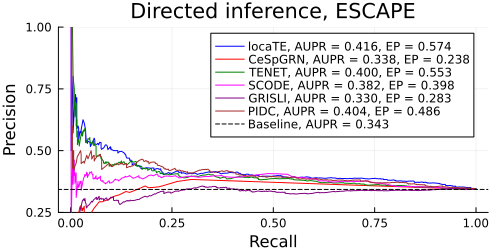

In [62]:
# compare to ESCAPE gold standard
regulators = vec(sum(J_escape; dims = 2) .> 0)
epfrac=0.1

plt1=plot(; title = "Directed inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0.25, 1.0))
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], cdf_norm2(reshape(agg_fun(TE), size(X, 2), size(X, 2)))[regulators, :], 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2))[regulators, :], 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_tenet[regulators, :], 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_scode[regulators, :], 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_grisli[regulators, :], 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_pidc[regulators, :], 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
hline!([mean(J_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_escape[regulators, :])), color = :black, linestyle = :dash)
plt1

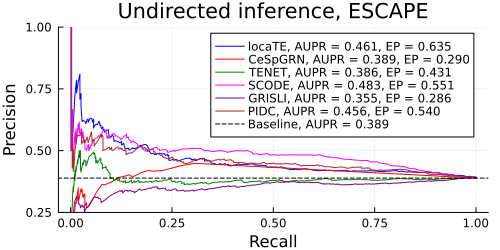

In [64]:
plt2=plot(; title = "Undirected inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0.25, 1.0))
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], cdf_norm2(reshape(agg_fun(locaTE.symm_row(TE, size(X, 2))), size(X, 2), size(X, 2)))[regulators, :], 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2))[regulators, :], 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_tenet)[regulators, :], 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_scode)[regulators, :], 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_grisli)[regulators, :], 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], G_pidc[regulators, :], 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
hline!([mean(J_symm_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_symm_escape[regulators, :])), color = :black, linestyle = :dash)
plt2